# CAE-LSTM Hybrid Model (Validation)

**Authors:** KHOO Jing Heng, Zayne SIEW

**Version:** 1.0 (05/04/2025)

### About this notebook

This notebook validates a trained CAE-LSTM model on the ECoG test data.

### Requirements

- Python 3
- Matplotlib
- Numpy
- Scipy
- Torch

## 0. Imports and Torch-CUDA Config

In [1]:
import numpy as np

import torch
from torch.utils.data import DataLoader

from constants import (
    CHANNELS_NUM,
    ECOG_VAL_FILEPATH,
    FLEXION_VAL_FILEPATH,
    SAMPLE_RATE,
    WAVELET_NUM,
)
from data import EcogDataset
from eval import pearson_correlation_metric, plot_fingerwise_timeseries, test_model
from model import EncoderDecoder

In [2]:
# For windows/linux will try CUDA first, then CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# Set default device for following code, so we don't need to specify device every time
torch.set_default_device(DEVICE)

cpu


## 1. Data and Model Loading

In [3]:
# Define directory where data is stored
DATA_DIR = "../data"

finger_flex_cropped_val: np.ndarray = np.load(f'{DATA_DIR}/{FLEXION_VAL_FILEPATH}')
X_spectrogram_cropped_val: np.ndarray = np.load(f'{DATA_DIR}/{ECOG_VAL_FILEPATH}')

val_dataset = EcogDataset(X_spectrogram_cropped_val, finger_flex_cropped_val)
print(X_spectrogram_cropped_val.shape, finger_flex_cropped_val.shape)
print(len(val_dataset))

(62, 40, 19980) (5, 19980)
19724


In [4]:
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

## 2. Model Validation

We test the trained model and calculate the mean Pearson correlation coefficients per finger, and in total.

In [5]:
model = EncoderDecoder(input_channels=CHANNELS_NUM * WAVELET_NUM, output_channels=5)
model.load_state_dict(torch.load("../0.5924338698387146.pth", map_location=DEVICE))

actuals, predictions = test_model(model, val_loader, device=DEVICE)
actuals = torch.tensor(actuals)
predictions = torch.tensor(predictions)

In [6]:
print(actuals.shape)
print(predictions.shape)

torch.Size([19724, 5, 256])
torch.Size([19724, 5, 256])


In [7]:
for i, finger in enumerate(['Thumb', 'Index', 'Middle', 'Ring', 'Little']):
    for j in range(256):
        print(
            f"CC ({finger} sample {j + 1}/256):",
            pearson_correlation_metric(predictions[:, i, j], actuals[:, i, j]).item(),
        )
    print(
        f"{finger} Mean Pearson CC:",
        pearson_correlation_metric(predictions[:, i, :], actuals[:, i, :]).item(),
    )

final_pearson = pearson_correlation_metric(torch.tensor(predictions), torch.tensor(actuals)).item()
print("Overall Mean Pearson CC:", final_pearson)

CC (Thumb sample 1/256): 0.529954731464386
CC (Thumb sample 2/256): 0.5305059552192688
CC (Thumb sample 3/256): 0.5399248600006104
CC (Thumb sample 4/256): 0.5405481457710266
CC (Thumb sample 5/256): 0.5352268218994141
CC (Thumb sample 6/256): 0.5350706577301025
CC (Thumb sample 7/256): 0.5355431437492371
CC (Thumb sample 8/256): 0.5359554886817932
CC (Thumb sample 9/256): 0.5332625508308411
CC (Thumb sample 10/256): 0.5341147184371948
CC (Thumb sample 11/256): 0.5354362726211548
CC (Thumb sample 12/256): 0.5360751152038574
CC (Thumb sample 13/256): 0.5373286604881287
CC (Thumb sample 14/256): 0.5376525521278381
CC (Thumb sample 15/256): 0.5389793515205383
CC (Thumb sample 16/256): 0.5389139652252197
CC (Thumb sample 17/256): 0.5363554954528809
CC (Thumb sample 18/256): 0.5366176962852478
CC (Thumb sample 19/256): 0.5369201898574829
CC (Thumb sample 20/256): 0.5371557474136353
CC (Thumb sample 21/256): 0.5371344089508057
CC (Thumb sample 22/256): 0.53721022605896
CC (Thumb sample 23/25

/opt/homebrew/lib/python3.11/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


## 3. Model Visualisation

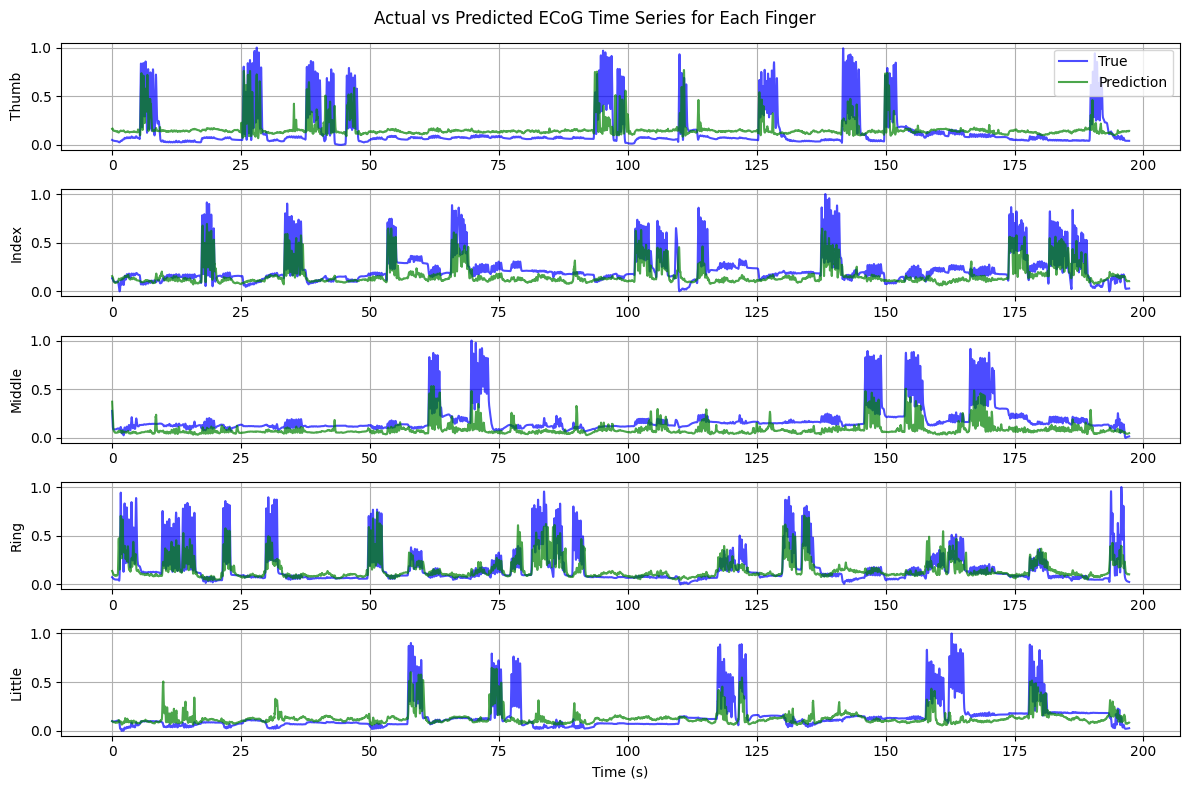

In [8]:
# Plot the actual and predicted ECoG signals for each finger
time_axis = np.arange(actuals.shape[0]) / SAMPLE_RATE # Time axis in seconds
plot_fingerwise_timeseries(actuals, predictions, time_axis=time_axis, sample=128)

/Users/zaynesiew/Documents/FingerECoG-BCI/src/eval.py:138: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/zaynesiew/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


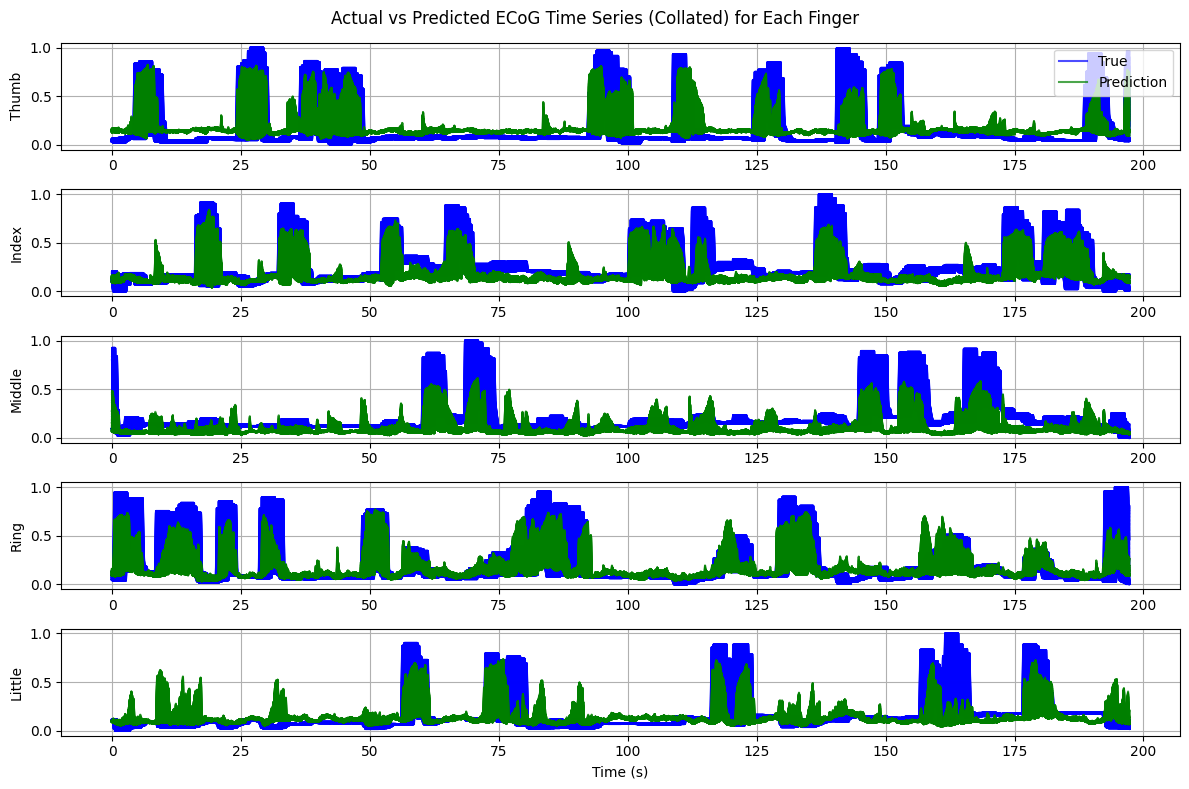

In [9]:
# Plot all samples, overlapping
plot_fingerwise_timeseries(actuals, predictions, time_axis=time_axis)